# Developing LSTM Models For Univariate Time Series Forecasting

In [1]:
# univariate lstm example
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [2]:
data = pd.read_excel("BrentOil.xlsx",parse_dates=['Date'], index_col='Date')
data.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [3]:
# Creating a list of monthly data list 
monthly_data_list = []
year_list = data.index.year.unique()
month_list = sorted(data.index.month.unique())
for year in year_list:
    for month in month_list:
        last_day_data = data[(data.index.year == year) &
                               (data.index.month == month)].tail(1)
        monthly_data_list.append(last_day_data)
data_monthly = pd.concat(monthly_data_list)
data_monthly.index = pd.to_datetime(
    data_monthly.index.strftime("%Y-%m"))  # reset index to YYYY-01-01
ts_log = np.log(data_monthly).copy()
data_monthly.head()

,Price
Date,
1987-05-01,18.58
1987-06-01,19.08
1987-07-01,20.03
1987-08-01,18.63
1987-09-01,18.48


In [4]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 428 entries, 1987-05-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   428 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


# Data preprocessing

In [5]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_features
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
timeseries_data = data_monthly['Price'].tolist()
print(timeseries_data)

[18.58, 19.08, 20.03, 18.63, 18.48, 18.8, 17.7, 17.6, 16.28, 14.73, 15.65, 16.6, 16.2, 14.18, 15.75, 14.4, 11.93, 12.6, 14.35, 16.23, 16.38, 17.23, 20.45, 20.15, 18.25, 18.28, 16.3, 17.2, 18.23, 18.93, 18.48, 21.05, 20.5, 19.2, 17.95, 16.35, 15.3, 15.73, 19.23, 27.8, 41.0, 34.3, 31.2, 28.35, 20.7, 19.5, 18.0, 19.7, 19.0, 18.48, 19.65, 20.53, 21.43, 22.0, 20.08, 17.75, 18.15, 17.45, 19.09, 19.65, 20.7, 20.6, 20.38, 19.65, 20.18, 19.13, 19.25, 17.85, 18.48, 18.83, 18.7, 18.85, 18.43, 17.43, 16.85, 16.73, 17.23, 15.43, 14.23, 13.18, 14.83, 13.59, 13.25, 15.35, 16.18, 17.45, 18.48, 16.03, 16.73, 17.18, 16.95, 16.23, 16.8, 17.23, 17.98, 18.98, 17.58, 16.58, 15.78, 16.2, 16.58, 16.58, 17.13, 18.65, 16.63, 18.8, 20.33, 19.5, 18.1, 19.28, 19.0, 20.98, 24.15, 22.8, 23.17, 23.9, 23.28, 19.44, 18.53, 18.25, 18.99, 18.22, 18.94, 17.98, 19.96, 19.42, 18.96, 15.86, 15.59, 13.53, 13.87, 13.79, 14.03, 11.84, 12.63, 12.06, 14.71, 12.0, 9.91, 10.54, 11.34, 10.58, 15.02, 16.45, 14.75, 16.97, 19.97, 21.08

In [7]:
# choose a number of time steps in months
n_steps = 12
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

In [8]:
print(X),print(y)

[[ 18.58  19.08  20.03 ...  14.73  15.65  16.6 ]
 [ 19.08  20.03  18.63 ...  15.65  16.6   16.2 ]
 [ 20.03  18.63  18.48 ...  16.6   16.2   14.18]
 ...
 [ 83.1   70.86  77.24 ... 111.51  96.55  88.9 ]
 [ 70.86  77.24  92.35 ...  96.55  88.9   93.3 ]
 [ 77.24  92.35 103.08 ...  88.9   93.3   85.61]]
[ 16.2   14.18  15.75  14.4   11.93  12.6   14.35  16.23  16.38  17.23
  20.45  20.15  18.25  18.28  16.3   17.2   18.23  18.93  18.48  21.05
  20.5   19.2   17.95  16.35  15.3   15.73  19.23  27.8   41.    34.3
  31.2   28.35  20.7   19.5   18.    19.7   19.    18.48  19.65  20.53
  21.43  22.    20.08  17.75  18.15  17.45  19.09  19.65  20.7   20.6
  20.38  19.65  20.18  19.13  19.25  17.85  18.48  18.83  18.7   18.85
  18.43  17.43  16.85  16.73  17.23  15.43  14.23  13.18  14.83  13.59
  13.25  15.35  16.18  17.45  18.48  16.03  16.73  17.18  16.95  16.23
  16.8   17.23  17.98  18.98  17.58  16.58  15.78  16.2   16.58  16.58
  17.13  18.65  16.63  18.8   20.33  19.5   18.1   19.28  19.  

(None, None)

In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [10]:
X.shape

(416, 12, 1)

# Building LSTM Model By Applying Recurrent Neural Network

In [32]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=1,shuffle = False)

Epoch 1/300
13/13 [==============================] - 5s 12ms/step - loss: 482.2296
Epoch 2/300
13/13 [==============================] - 0s 12ms/step - loss: 179.1878
Epoch 3/300
13/13 [==============================] - 0s 12ms/step - loss: 79.5048
Epoch 4/300
13/13 [==============================] - 0s 12ms/step - loss: 80.9478
Epoch 5/300
13/13 [==============================] - 0s 13ms/step - loss: 66.9038
Epoch 6/300
13/13 [==============================] - 0s 12ms/step - loss: 104.8581
Epoch 7/300
13/13 [==============================] - 0s 13ms/step - loss: 178.6497
Epoch 8/300
13/13 [==============================] - 0s 14ms/step - loss: 179.7510
Epoch 9/300
13/13 [==============================] - 0s 13ms/step - loss: 114.4247
Epoch 10/300
13/13 [==============================] - 0s 14ms/step - loss: 93.3493
Epoch 11/300
13/13 [==============================] - 0s 14ms/step - loss: 77.7206
Epoch 12/300
13/13 [==============================] - 0s 13ms/step - loss: 62.5111
Epoch 1

13/13 [==============================] - 0s 12ms/step - loss: 38.9870
Epoch 100/300
13/13 [==============================] - 0s 13ms/step - loss: 37.1363
Epoch 101/300
13/13 [==============================] - 0s 13ms/step - loss: 39.3526
Epoch 102/300
13/13 [==============================] - 0s 12ms/step - loss: 38.0616
Epoch 103/300
13/13 [==============================] - 0s 13ms/step - loss: 38.6157
Epoch 104/300
13/13 [==============================] - 0s 12ms/step - loss: 37.2068
Epoch 105/300
13/13 [==============================] - 0s 12ms/step - loss: 39.8585
Epoch 106/300
13/13 [==============================] - 0s 13ms/step - loss: 39.1173
Epoch 107/300
13/13 [==============================] - 0s 13ms/step - loss: 38.7549
Epoch 108/300
13/13 [==============================] - 0s 14ms/step - loss: 36.5529
Epoch 109/300
13/13 [==============================] - 0s 12ms/step - loss: 39.3931
Epoch 110/300
13/13 [==============================] - 0s 13ms/step - loss: 37.6731
Epoch 

13/13 [==============================] - 0s 13ms/step - loss: 31.3257
Epoch 197/300
13/13 [==============================] - 0s 12ms/step - loss: 31.6131
Epoch 198/300
13/13 [==============================] - 0s 13ms/step - loss: 28.8186
Epoch 199/300
13/13 [==============================] - 0s 14ms/step - loss: 29.4216
Epoch 200/300
13/13 [==============================] - 0s 13ms/step - loss: 26.2049
Epoch 201/300
13/13 [==============================] - 0s 12ms/step - loss: 26.6601
Epoch 202/300
13/13 [==============================] - 0s 13ms/step - loss: 23.6670
Epoch 203/300
13/13 [==============================] - 0s 12ms/step - loss: 26.7518
Epoch 204/300
13/13 [==============================] - 0s 15ms/step - loss: 21.6212
Epoch 205/300
13/13 [==============================] - 0s 17ms/step - loss: 22.7217
Epoch 206/300
13/13 [==============================] - 0s 16ms/step - loss: 21.1369
Epoch 207/300
13/13 [==============================] - 0s 16ms/step - loss: 24.8794
Epoch 

13/13 [==============================] - 0s 15ms/step - loss: 183.8300
Epoch 294/300
13/13 [==============================] - 0s 13ms/step - loss: 130.1504
Epoch 295/300
13/13 [==============================] - 0s 12ms/step - loss: 213.7187
Epoch 296/300
13/13 [==============================] - 0s 15ms/step - loss: 148.8200
Epoch 297/300
13/13 [==============================] - 0s 16ms/step - loss: 164.4603
Epoch 298/300
13/13 [==============================] - 0s 14ms/step - loss: 266.3035
Epoch 299/300
13/13 [==============================] - 0s 11ms/step - loss: 72.6699
Epoch 300/300
13/13 [==============================] - 0s 12ms/step - loss: 52.1323


# Predicting For the next 36 months data

In [33]:
# demonstrate prediction for next 10 days
x_input = np.array([92.35, 103.08, 107.29, 108.36, 125.53, 119.78, 111.51, 96.55, 88.9, 93.3, 85.61, 81.66])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<37):
    
    if(len(temp_input)>12):
        x_input=np.array(temp_input[1:])
        print("{} month input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} month output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

[72.67357]
1 month input [103.08       107.29       108.36       125.53       119.78
 111.51        96.55        88.9         93.3         85.61
  81.66        72.67356873]
1 month output [[68.39126]]
2 month input [107.29       108.36       125.53       119.78       111.51
  96.55        88.9         93.3         85.61        81.66
  72.67356873  68.39125824]
2 month output [[64.07915]]
3 month input [108.36       125.53       119.78       111.51        96.55
  88.9         93.3         85.61        81.66        72.67356873
  68.39125824  64.07914734]
3 month output [[59.922123]]
4 month input [125.53       119.78       111.51        96.55        88.9
  93.3         85.61        81.66        72.67356873  68.39125824
  64.07914734  59.92212296]
4 month output [[55.94206]]
5 month input [119.78       111.51        96.55        88.9         93.3
  85.61        81.66        72.67356873  68.39125824  64.07914734
  59.92212296  55.94205856]
5 month output [[52.93414]]
6 month input [111.51 

In [34]:
# These are predected prices of the next 36 month 
lst_output

[72.67357,
 68.39126,
 64.07915,
 59.922123,
 55.94206,
 52.93414,
 50.436256,
 47.77388,
 45.338657,
 43.145844,
 41.39499,
 40.126072,
 39.1415,
 38.347256,
 37.662495,
 37.038036,
 36.449493,
 35.90259,
 35.437,
 35.068558,
 34.77603,
 34.534355,
 34.30019,
 34.075367,
 33.83892,
 33.59783,
 33.35969,
 33.131756,
 32.919647,
 32.726017,
 32.54959,
 32.38753,
 32.23637,
 32.093063,
 31.955612,
 31.823273,
 31.69603]

# Visualizaing The Output

In [35]:
import matplotlib.pyplot as plt

In [36]:
month_new=np.arange(1,429)
month_pred=np.arange(429,466)

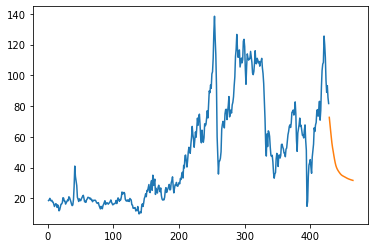

In [37]:
plt.plot(month_new,timeseries_data)
plt.plot(month_pred,lst_output)